# Overview

This notebook trains on the CIFAR-10 dataset, a collection of 32x32 images divided into 10 classes:
- Aircraft
- Birds
- Cats
- Dogs
- Flowers
- Fish
- Fruits
- Cars
- Trucks
- Ships

The goal is to correctly classify an image with one of the above features.

## General Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

In [2]:
# Set a seed so that results can be reproduced
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)               # PyTorch CPU
    torch.cuda.manual_seed(seed)          # PyTorch GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset

In [3]:
# We can download the dataset through torchvision
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

When we use torchvision to download the dataset it will create a Pytorch Dataset object.
This dataset object is used to pull samples.
It can also apply transforms (i.e. image augmentation) during the pulling process.

We want to apply transforms to these images as it will provide some variability in our training data and help to avoid overfitting.

In [4]:
# Define our image augmentation
img_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),       # Flip image horizontally with 50% chance
    transforms.RandomCrop(32, padding=4),    # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Random color changes
    transforms.ToTensor(),
])

In [5]:
train_pct = 0.8

complete_train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=img_augmentation)

# Split into train/validation split
train_size = int(train_pct * len(complete_train_data))
val_size = len(complete_train_data) - train_size

# Split the dataset
train_subset, val_subset = random_split(complete_train_data, [train_size, val_size])

Files already downloaded and verified


In [6]:
def show_unaugmented_image(index=0):
    # Load CIFAR-10 without any transforms
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False)

    # Get image and label
    image, label = dataset[index]

    # Convert PIL image to numpy array for plotting
    image_np = np.array(image)

    # Plot the image
    plt.imshow(image_np)
    plt.title(f"Label: {dataset.classes[label]}")
    plt.axis('off')
    plt.show()

def show_augmented_image(index=0):
    # Load CIFAR-10 with transforms
    dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=img_augmentation)

    # Get image and label
    image, label = dataset[index]  # image is now a tensor

    # Convert tensor to numpy array and rearrange dimensions
    image_np = image.permute(1, 2, 0).numpy()

    # Clip values to [0, 1] for display
    image_np = np.clip(image_np, 0, 1)

    # Plot the image
    plt.imshow(image_np)
    plt.title(f"Label: {dataset.classes[label]}")
    plt.axis('off')
    plt.show()

In [7]:
img_index = 0

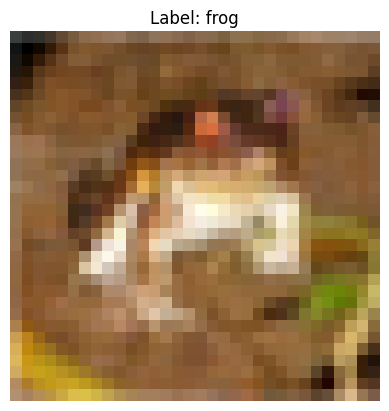

In [8]:
show_unaugmented_image(img_index)

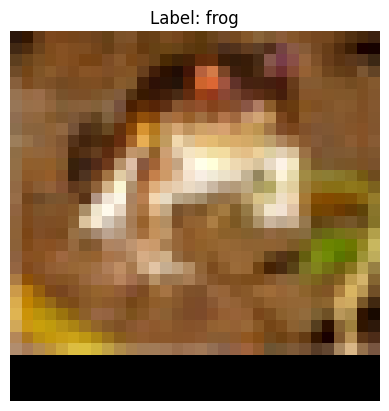

In [9]:
show_augmented_image(img_index)

In [10]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image

import torchvision
import torchvision.transforms as transforms

from IPython.display import display

# Neural Net

In [11]:
from VGGNet import VGGNet

In [12]:
# Setting the model to a variable in case we want to use/implement a different model
model_cnn = VGGNet

# Train

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Parameters
batch_size = 32
epochs = 20

In [15]:
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)

In [16]:
model = model_cnn(input_size = complete_train_data[0][0].size(), output_size = len(complete_train_data.classes))
model.to(device)

VGGNet(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bia

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
train_losses = []
valid_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images = images.float().to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_losses.append(train_loss/len(train_loader))
    
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.float().to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            
            # Compute predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
        
    valid_losses.append(valid_loss/len(valid_loader))
    
    val_acc = correct/len(valid_loader.dataset)
    
    print(f"Epoch {epoch + 1}:\n\tTrain Loss = {train_losses[-1]:.4f}\n\tValid Loss = {valid_losses[-1]:.4f}")
    print(f"\tAccuracy: {val_acc}")

Epoch 1:
	Train Loss = 1.8291
	Valid Loss = 1.5463
	Accuracy: 0.4306
Epoch 2:
	Train Loss = 1.4362
	Valid Loss = 1.2780
	Accuracy: 0.5359
Epoch 3:
	Train Loss = 1.2371
	Valid Loss = 1.0687
	Accuracy: 0.6159
Epoch 4:
	Train Loss = 1.1033
	Valid Loss = 1.0640
	Accuracy: 0.6188
Epoch 5:
	Train Loss = 1.0210
	Valid Loss = 0.9392
	Accuracy: 0.6655
Epoch 6:
	Train Loss = 0.9615
	Valid Loss = 0.9464
	Accuracy: 0.6638
Epoch 7:
	Train Loss = 0.9080
	Valid Loss = 0.8984
	Accuracy: 0.6855
Epoch 8:
	Train Loss = 0.8749
	Valid Loss = 0.8818
	Accuracy: 0.695
Epoch 9:
	Train Loss = 0.8420
	Valid Loss = 0.8477
	Accuracy: 0.7023
Epoch 10:
	Train Loss = 0.8086
	Valid Loss = 0.7782
	Accuracy: 0.7316
Epoch 11:
	Train Loss = 0.7850
	Valid Loss = 0.7639
	Accuracy: 0.7363
Epoch 12:
	Train Loss = 0.7682
	Valid Loss = 0.7857
	Accuracy: 0.7286
Epoch 13:
	Train Loss = 0.7481
	Valid Loss = 0.7492
	Accuracy: 0.739
Epoch 14:
	Train Loss = 0.7346
	Valid Loss = 0.7561
	Accuracy: 0.7427
Epoch 15:
	Train Loss = 0.7279


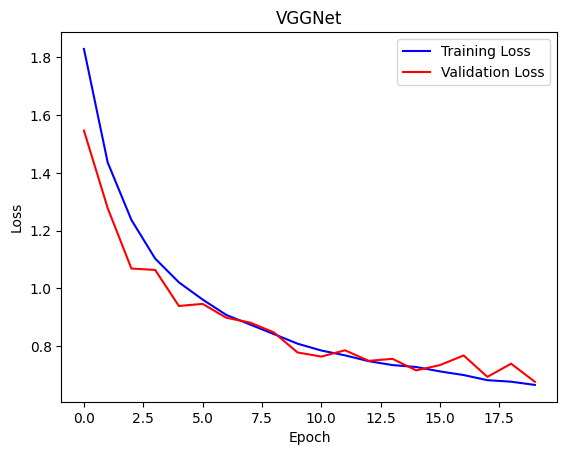

In [19]:
plt.title(model.__class__.__name__)
plt.plot(train_losses, color='blue', label='Training Loss')
plt.plot(valid_losses, color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()